This research presents preliminary findings and is being distributed to interested readers solely to stimulate discussion and elicit comments.

Notes: MCC vs Accuracy, source: https://towardsdatascience.com/the-best-classification-metric-youve-never-heard-of-the-matthews-correlation-coefficient-3bf50a2f3e9a

    TODO: Intro Para on data for training and testing 
    TODO: Explain CAMELS ratios
    TODO: Explain MCC and why it is important for imbalanced samples like this one
    TODO: Add timer to the Grid Search 
    TODO: Plot the tree and/or feature importances

In [194]:
# Important notes on CAMELS valuation framework, consider feature eng to add lagged values as well:
# (C)apital adequace can be measure by 
#       1) Total Equity / Total Assets (EQTA)
#       2) Total Equity / Total Loans (EQTL)
#       - consider also risk-weighted capital adequacy ratio
# (A)sset quality
#       3) Non Performing Loans / Total Assets (NPLTA)
#       4) Non Performing Loans / Gross Loans (NPLGL)
#       5) Loan Loss Reserves / Total Assest (LLRTA)
#       6) Loan Loss Reserves / Gross Loans (LLRGL)
#       - consider Net Interest Margin
# (M)anagement quality
#       7) Operating Costs / Net Operating Income (OCNOI)
#       - Operating Expenses / Assets (OEXTA)
# (E)arnings ability
#       8) Net Income / Total Assest (ROA)
#       9) Net Income / Total Equity (ROE)
#      - consider Net Interest Margin
# (L)iquidity, i.e. ability to fulfill its short-term liability
#       10) Total Loans / Total Customer Deposits (TLTD)
#       11) Total Customer Deposits / Total Assest (TDTA)
#        - consider liquid assets to total assets ratio
#        - liquid assets to deposits ratio
# (S)ensitivity to market risk 
#       12) Trading Income / Net Operatin Income (TINOI)
# Condider adding control variables: Assest Size, GDP growth, Inflation, Interest RAtes (3M, 6M, 12M, 36M)




# CAMELS representation, source: https://en.wikipedia.org/wiki/CAMELS_rating_system

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, validation_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_curve 
from sklearn.metrics import precision_recall_curve, roc_curve, matthews_corrcoef
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline
# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

### 1. Preprocessing

In [2]:
file_path = "data/camel_data_after2010Q3.csv"
banks_df = pd.read_csv(file_path, index_col=0)

Check if there are any missing values and drop `null`

In [3]:
banks_df.dropna(inplace=True)

Show the features of failed banks (Target of 1) and count them

In [4]:
banks_df.loc[banks_df.Target == 1].count()

AsOfDate    137
Target      137
EQTA        137
EQTL        137
LLRTA       137
LLRGL       137
OEXTA       137
INCEMP      137
ROA         137
ROE         137
TDTL        137
TDTA        137
TATA        137
dtype: int64

Take a copy of predictors and store in X, count all instances available.

In [5]:
X = banks_df[['EQTA', 'EQTL', 'LLRTA', 'LLRGL', 'OEXTA', 'INCEMP', 'ROA', 'ROE', 'TDTL', 'TDTA', 'TATA']].copy()
len(X)

7014

Define the target vector y and reshape it as well.

In [6]:
y = banks_df["Target"].values.reshape(-1, 1)

### 2. Developing basic GBM 

First train/test split, note `random_state=123` for the auditing purposes.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

Creating `StandardScaler` object and fitting, i.e. removing the mean and scaling to unit variance.

In [8]:
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

Transforming training and testing features data using the fitted scaler.

In [9]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### 3. Optimizing Sensitivity (Minimizing Type II Error) with `GridSearch`

In [118]:
param_grid = {'learning_rate': [0.05, 0.1, 0.2, 0.5, 0.7, 0.8, 0.9], 
             "n_estimators" : [20, 30, 40, 50],
              "max_features": [2, 3, 4, 5],
              "max_depth" : [2, 3, 4, 5]} 

grid = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring = 'recall', cv=5)
grid.fit(X, y.ravel());
grid.best_params_


{'learning_rate': 0.1, 'max_depth': 2, 'max_features': 5, 'n_estimators': 20}

Take note of these params below:

    `{'learning_rate': 0.1, 'max_depth': 2, 'max_features': 3, 'n_estimators': 30}`

**Take note of four evaluation metrics:**
- Accuracy: (TP + TN)/(TP + TN + FP + FN)
- Misclassification Rate: 1 - Accuracy or (FP + FN)/(TP + TN + FP + FN)
- Sensitivity (Recall or True Positive Rate): TP / (TP + FN)
- Specificity: TN / (TN + FN)
- False Positive Rate: FP / (TN + FP)
- Precision: TP / (TP + FP)

### 4. Evaluating the best GBM model

In [132]:
clf_best = GradientBoostingClassifier(n_estimators=20,
                                     learning_rate=0.1,
                                     max_features=5,
                                     max_depth=2,
                                     random_state=123)

clf_best.fit(X_train_scaled, y_train.ravel())
predictions = clf_best.predict(X_test_scaled)
print("Testing accuracy: {0:.3f}%".format(accuracy_score(predictions, y_test) * 100 ))
pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel()}).head(5)

Testing accuracy: 98.746%


,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


#### Check for Null Accuracy, i.e. always predicting majority class. Start with class distribution below:

In [133]:
y_true = pd.DataFrame(y_test, columns=['y_true'])
y_true["y_true"].value_counts()

0    1725
1      29
Name: y_true, dtype: int64

In [134]:
print('Calculate the percentage of ones: {0:.3f}%'.format(y_true["y_true"].mean() * 100))

Calculate the percentage of ones: 1.653%


In [135]:
print('Calculate Null accuracy for binary classification: {0:.3f}%'.format(
    max(y_true["y_true"].mean(), 1 - y_true["y_true"].mean()) *100))

Calculate Null accuracy for binary classification: 98.347%


#### Model Performance over Thresholds

The precision-recall curve plots the relationship between precision and recall as the decision threshold changes. Recall is the ability of a model to detect all positive samples and precision is the ability of a model to avoid labeling negative samples as positive. Some business problems might require higher recall and some higher precision depending on the relative importance of avoiding false negatives vs false positives.

Average precision-recall score: 0.66


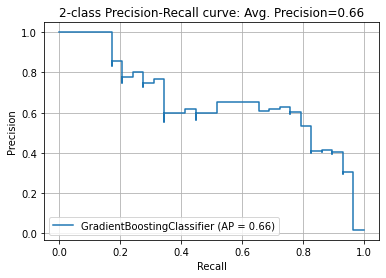

In [156]:
y_score = clf_best.decision_function(X_test_scaled)

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(clf_best, X_test_scaled, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'Avg. Precision={0:0.2f}'.format(average_precision))
plt.grid(True)

The receiver operating characteristic (ROC) curve plots the relationship between true positive rate (TPR) and false positive rate (FPR) as the decision threshold changes. The ROC curve can be less informative when training models on datasets with high class imbalance, as the majority class can drown out contributions from minority classes.

The area under the curve (AUC) can be interpreted as the proportion of correctly classified samples. More precisely, the AUC is the probability that the classifier ranks a randomly chosen positive sample higher than a randomly chosen negative sample. The shape of the curve gives an intuition for relationship between TPR and FPR as a function of the classification threshold or decision boundary.



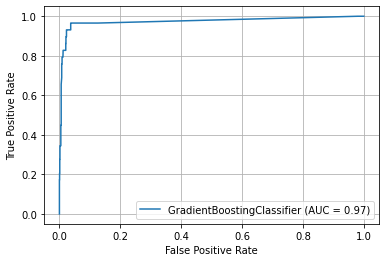

In [155]:
from sklearn.metrics import plot_roc_curve
clf_best_disp = plot_roc_curve(clf_best, X_test_scaled, y_test)
clf_best_disp.plot(ax=ax, alpha=0.8)
plt.grid(True)
plt.show()


#### Generate the confusion matrix

In [138]:
pd.DataFrame(confusion_matrix(y_test, predictions), index=["True 0", "True 1"], 
             columns=["Predicted 0", "Predicted 1"])

,Predicted 0,Predicted 1
True 0,1712,13
True 1,9,20


In [139]:
print( "Total Actual Survived: ", 1707 + 18)
print("Total Actual Failed: ", 9 + 20)

Total Actual Survived:  1725
Total Actual Failed:  29


In [140]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
tn, fp, fn, tp

(1712, 13, 9, 20)

In [144]:
print("recall: {0:.2f}".format(tp/(tp+fn)))
print("precision: {0:.2f}".format(tp/(tp+fp))) #TP / (TP + FP)

recall: 0.69
precision: 0.61


#### Compute Matthews correlation (MCC)

In [145]:
matthews_corrcoef(y_test, predictions)
print("Matthews Correlation is {0:.3f}".format(matthews_corrcoef(y_test, predictions)))

Matthews Correlation is 0.640


#### Generate classification report

In [146]:
print("In-Sample Classification Report")
print(classification_report(y_test, predictions))

In-Sample Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1725
           1       0.61      0.69      0.65        29

    accuracy                           0.99      1754
   macro avg       0.80      0.84      0.82      1754
weighted avg       0.99      0.99      0.99      1754



### 5. Analysing rules that were learned in training

#### Extracting rules and feature importances 

In [115]:
n_classes, n_estimators = clf_best.estimators_.shape

for c in range(n_classes):
    
    for t in range(n_estimators):
        
        dtree = clf_best.estimators_[c, t]
        rules_df = pd.DataFrame({
            'child_left': dtree.tree_.children_left,
            'child_right': dtree.tree_.children_right,
            'feature': dtree.tree_.feature,
            'threshold': dtree.tree_.threshold,
        })
rules_df.head()

,child_left,child_right,feature,threshold
0,1,8,1,-0.023284
1,2,5,6,-2.327335
2,3,4,9,1.581137
3,-1,-1,-2,-2.000000
4,-1,-1,-2,-2.000000


#### TODO: plot decision tree

### 6. Out-of-sample GBM testing 

In [147]:
pd.set_option('use_inf_as_na', True)

oos_reports = ['2010Q4', '2011Q1', '2011Q2', '2011Q3', '2011Q4', '2012Q1', '2012Q2', 
               '2012Q3', '2012Q4', '2019Q2']

for report in oos_reports:
    
    oos_df = pd.read_csv('oos/camel_data_after{}_OOS.csv'.format(report))
    oos_df.replace([np.inf, -np.inf], np.nan)
    oos_df.dropna(inplace=True)
    
    y_oos = oos_df['Target']
    X_oos = oos_df[['EQTA', 'EQTL', 'LLRTA', 'LLRGL', 'OEXTA', 'INCEMP', 'ROA', 'ROE', 
                    'TDTL', 'TDTA', 'TATA']].copy()
    X_oos_scaled = X_scaler.transform(X_oos) 
    
    predictions_oos = clf_best.predict(X_oos_scaled)
    mcc = np.round(matthews_corrcoef(y_oos, predictions_oos), 2)
    
    # Generate out-of-sample MCC and classification report 
    print("*" * 55, "\nMatthews Correlation (MCC) for {} is {}".format(report, mcc))
    print("*" * 55,"\nOut-of-sample (OOS) Classification Report for {}:".format(report))
    print(classification_report(y_oos, predictions_oos), "\n\n")
   
  

******************************************************* 
Matthews Correlation (MCC) for 2010Q4 is 0.66
******************************************************* 
Out-of-sample (OOS) Classification Report for 2010Q4:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6779
           1       0.53      0.83      0.65        24

    accuracy                           1.00      6803
   macro avg       0.76      0.92      0.82      6803
weighted avg       1.00      1.00      1.00      6803
 


******************************************************* 
Matthews Correlation (MCC) for 2011Q1 is 0.49
******************************************************* 
Out-of-sample (OOS) Classification Report for 2011Q1:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6713
           1       0.24      1.00      0.38        19

    accuracy                           0.99      6732
   macro avg       0.62 

In [158]:
0.76*25

19.0

## Visual Data Analysis

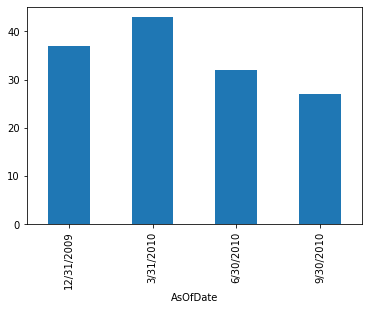

In [181]:
df = pd.read_csv('data/failed_universe.csv', index_col=0)
df.groupby('AsOfDate').Target.count().plot(kind='bar')
plt.show()

In [183]:
df2 = pd.read_csv('data/failed_banks_dataset.csv', index_col=0)
df2.tail()

,City,ST,CERT,Acquiring Institution,Closing Date,Updated Date
Bank Name,,,,,,
"Superior Bank, FSB",Hinsdale,IL,32646,"Superior Federal, FSB",27-Jul-01,19-Aug-14
Malta National Bank,Malta,OH,6629,North Valley Bank,3-May-01,18-Nov-02
First Alliance Bank & Trust Co.,Manchester,NH,34264,Southern New Hampshire Bank & Trust,2-Feb-01,18-Feb-03
National State Bank of Metropolis,Metropolis,IL,3815,Banterra Bank of Marion,14-Dec-00,17-Mar-05
Bank of Honolulu,Honolulu,HI,21029,Bank of the Orient,13-Oct-00,17-Mar-05


In [192]:
df3 = pd.read_csv('data/core_banks_dataset.csv')
df3.head()

,12/31/2002,3/31/2003,6/30/2003,9/30/2003,12/31/2003,3/31/2004,6/30/2004,9/30/2004,12/31/2004,3/31/2005,...,3/31/2017,6/30/2017,9/30/2017,12/31/2017,3/31/2018,6/30/2018,9/30/2018,12/31/2018,3/31/2019,6/30/2019
0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,...,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0
1,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0,...,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0,242.0
2,279.0,279.0,279.0,279.0,279.0,279.0,279.0,279.0,279.0,279.0,...,279.0,279.0,279.0,279.0,279.0,279.0,279.0,279.0,279.0,279.0
3,354.0,354.0,354.0,354.0,354.0,354.0,354.0,354.0,354.0,354.0,...,354.0,354.0,354.0,354.0,354.0,354.0,354.0,354.0,354.0,354.0
4,439.0,439.0,439.0,439.0,439.0,439.0,439.0,439.0,439.0,439.0,...,457.0,457.0,457.0,457.0,457.0,457.0,457.0,457.0,457.0,457.0


In [193]:
df3.shape

(8468, 67)